- Summary
- Business Understanding\
   Apple looking to understand positive and negative sentiment around their products and how to improve. Focusing on neutral 
   and negative sentiment tweets as demographics to focus on.
- Data Understanding


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [66]:
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')

In [67]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [68]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [69]:
df['tweet_text_lower'] = df['tweet_text'].str.lower()

In [70]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_lower
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,@sxtxstate great stuff on fri #sxsw: marissa m...


Checking if any Apple terms are in tweet_text to work with all apple related tweets since there are many missing values in
'emotion_in_tweet_is_directed_at'

In [71]:
apple_related = 'ipad|apple|iphone|itunes'

In [72]:
df['tweet_text_lower'].str.contains(apple_related).sum()

5592

In [73]:
df.shape

(9093, 4)

Dropping the one row with missing tweet_text

In [74]:
df.dropna(subset=['tweet_text'], inplace=True)

In [75]:
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy()

In [76]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   emotion_in_tweet_is_directed_at                     2417 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
 3   tweet_text_lower                                    5592 non-null   object
dtypes: object(4)
memory usage: 218.4+ KB


In [77]:
apple_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              659
iPad or iPhone App                 454
iPhone                             296
Other Apple product or service      35
Android                              9
Android App                          8
Google                               7
Other Google product or service      3
Name: emotion_in_tweet_is_directed_at, dtype: int64

Dropping Columns 'emotion_in_tweet_is_direct_at' because we have focused on all Apple related tweets already and will analyze sentiment from there.

In [78]:
apple_df.drop(columns=['emotion_in_tweet_is_directed_at', 'tweet_text_lower'], axis=1, inplace=True)

In [79]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
dtypes: object(2)
memory usage: 131.1+ KB


In [80]:
apple_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    2929
Positive emotion                      2144
Negative emotion                       420
I can't tell                            99
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [81]:
def custom_encoder(apple_df):
    apple_df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
    apple_df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    apple_df.replace(to_replace ="Negative emotion", value =0, inplace=True)
    apple_df.replace(to_replace ="I can't tell", value =2, inplace=True)

In [82]:
custom_encoder(apple_df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [83]:
apple_df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2


In [84]:
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [85]:
apple_df.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2


In [86]:
apple_df.duplicated().sum()

5

In [87]:
apple_df.drop_duplicates(inplace=True)

In [88]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   emotion     5587 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 130.9+ KB


# Train Test Split

In [89]:
apple_df = apple_df.copy()

In [90]:
from sklearn.model_selection import train_test_split

X = apple_df.drop(columns=['emotion'], axis=1)
y = apple_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [91]:
train_sample = X_train.sample(5, random_state=42)
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text
7403,#SXSW -Apple Pop-Up Store being set up right now on 6th St. My fellow truck driver is delivering the furniture NOW.
5609,RT @mention Check out the #dokobots game from @mention for iPhone and Android. Seems pretty cool. #geogames #SXSW #tmsxsw
8988,It's crazy here at #Apple's temporary #Austin store. Post coming up with pics. #SXSW
2394,At #SXSW conf and EVERYONE has a Mac or Ipad (including me). What happened to the PC? Is it becoming obsolete?
2461,"free #iPad Lounge open daily for #SXSW serving art made on iPads, and local art, free coffee, @mention Austin Details {link} #photo"


# Wes

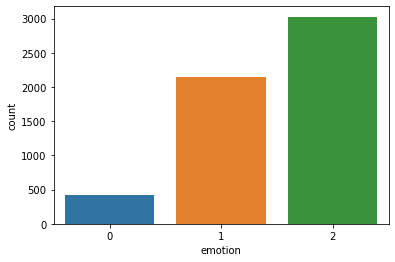

In [92]:
sns.countplot(x='emotion', data=apple_df);

- Emotion is unbalanced target with much fewer negative tweets. (0 is negative, 1 is positive, 2 is neutral/can't tell)

Preprocessing

-Starting with lowercasing

In [93]:
X_train["tweet_text"] = X_train["tweet_text"].str.lower()

In [94]:
X_train.iloc[100]['tweet_text']

"it's clear i will never be cool at #sxsw because i am without an ipad. and i'm generally not cool. doubly handicapped"

In [95]:
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

In [96]:
X_train["text_tokenized"] = X_train["tweet_text"].apply(tokenizer.tokenize)

In [97]:
X_train.iloc[100]["text_tokenized"][:20]

['it',
 'clear',
 'will',
 'never',
 'be',
 'cool',
 'at',
 'sxsw',
 'because',
 'am',
 'without',
 'an',
 'ipad',
 'and',
 'generally',
 'not',
 'cool',
 'doubly',
 'handicapped']

In [98]:
from nltk import FreqDist

train_freq_dist = FreqDist(X_train["text_tokenized"].explode())

In [99]:
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):
    
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=45)
    

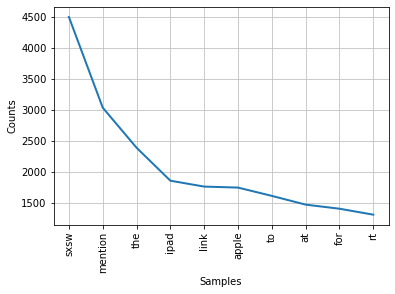

In [100]:
train_freq_dist.plot(10, cumulative=False);

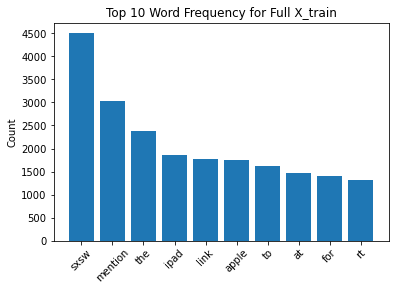

In [101]:
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Full X_train")

 - Dropping emotion_in_tweet_is_directed_at for now just to analyze tweets and overall sentiment irregardless of brand.

IndexError: list index out of range

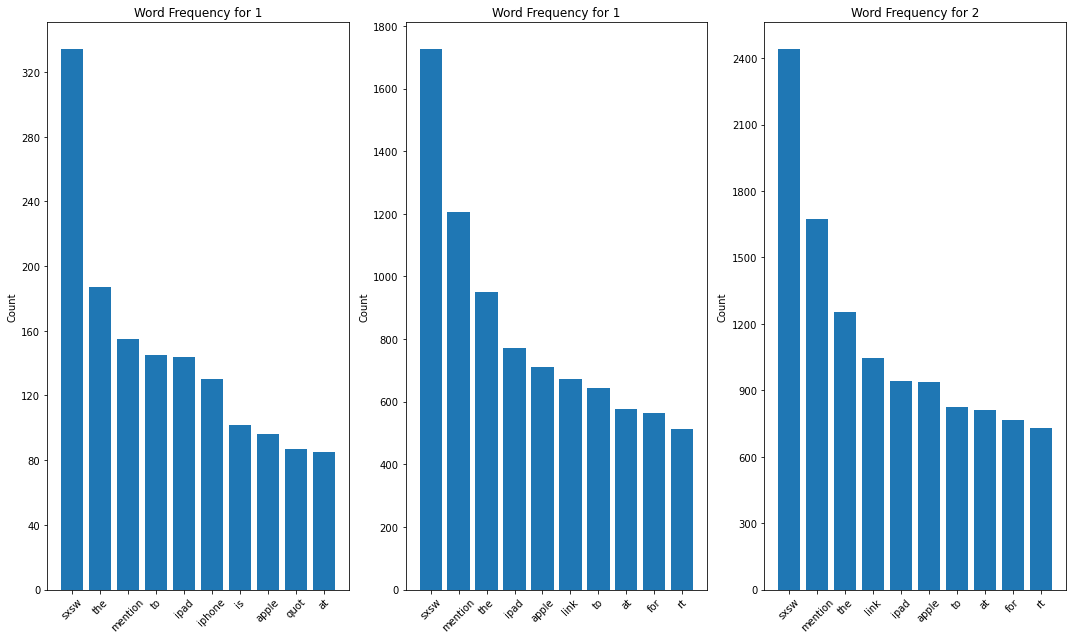

In [102]:
X_train["emotion"] = [y_train[val] for val in X_train.index]

def setup_three_subplots():
    
    fig = plt.figure(figsize=(15,9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 6)
    ax1 = fig.add_subplot(gs[0, :2]) # row 0, cols 0-1
    ax2 = fig.add_subplot(gs[0, 2:4])# row 0, cols 2-3
    ax3 = fig.add_subplot(gs[0, 4:]) # row 0, cols 4-5
    return fig, [ax1, ax2, ax3]

def plot_distribution_of_column_by_category(column, axes, title="Word Frequency for"):
    for index, category in enumerate(X_train.emotion):
        # Calculate frequency distribution for this subset
        all_words = X_train[X_train["emotion"] == index][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax = axes[index]
        ax.bar(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=45)


fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("text_tokenized", axes)
fig.suptitle("Word Frequencies for All Tokens", fontsize=24);

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,apple,at,for,ipad,link,mention,rt,sxsw,the,to
0,0.000000,0.000000,0.638839,0.000000,0.000000,0.480822,0.000000,0.289020,0.526462,0.000000
1,0.381775,0.417109,0.000000,0.719358,0.000000,0.000000,0.000000,0.194166,0.353682,0.000000
2,0.000000,0.000000,0.615714,0.516009,0.526342,0.000000,0.000000,0.278558,0.000000,0.000000
3,0.000000,0.628022,0.000000,0.000000,0.000000,0.486356,0.000000,0.292347,0.532522,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.714224,0.484153,0.214659,0.000000,0.457604
...,...,...,...,...,...,...,...,...,...,...
4185,0.472242,0.515949,0.000000,0.000000,0.000000,0.399564,0.541707,0.240177,0.000000,0.000000
4186,0.000000,0.392486,0.000000,0.000000,0.000000,0.607901,0.000000,0.182704,0.665605,0.000000
4187,0.000000,0.000000,0.000000,0.391481,0.399320,0.703161,0.000000,0.211334,0.384953,0.000000
4188,0.000000,0.000000,0.615714,0.516009,0.526342,0.000000,0.000000,0.278558,0.000000,0.000000


Double checking the shape of vectorized data. Same number of rows and 10 columns because max_features=10

In [104]:
assert X_train_vectorized.shape[0] == X_train.shape[0]
assert X_train_vectorized.shape[1] == 10

Fitting and evaluating a Multinomial Naive Bayes Classifier using cross_val_score as baseline model

In [105]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

baseline_model = MultinomialNB()

baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

0.5365155131264916

In [106]:
y_train.value_counts(normalize=True)

2    0.536516
1    0.386874
0    0.076611
Name: emotion, dtype: float64

This model appears to guess the majority class of neutral with almost exactly the same accuracy that it appears. 

# Iterate upon the model using different Prepocessing and Feature Engineering

# Removing Stopwords

In [107]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

Appending stopwords "sxsw" and "mention" because they appear very often because the twitter users are at SXSW and mention is an artifact from the twitter platform.

In [108]:
stopwords_list.append('sxsw')
stopwords_list.append('mention')
stopwords_list.remove('not')

In [109]:
stopwords_list[-3:]

["wouldn't", 'sxsw', 'mention']

# Making a function to remove stopwords and applying it to X_train

In [110]:
def remove_stopwords(token_list):
    
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [111]:
X_train["text_without_stopwords"] = X_train["text_tokenized"].apply(remove_stopwords)

IndexError: list index out of range

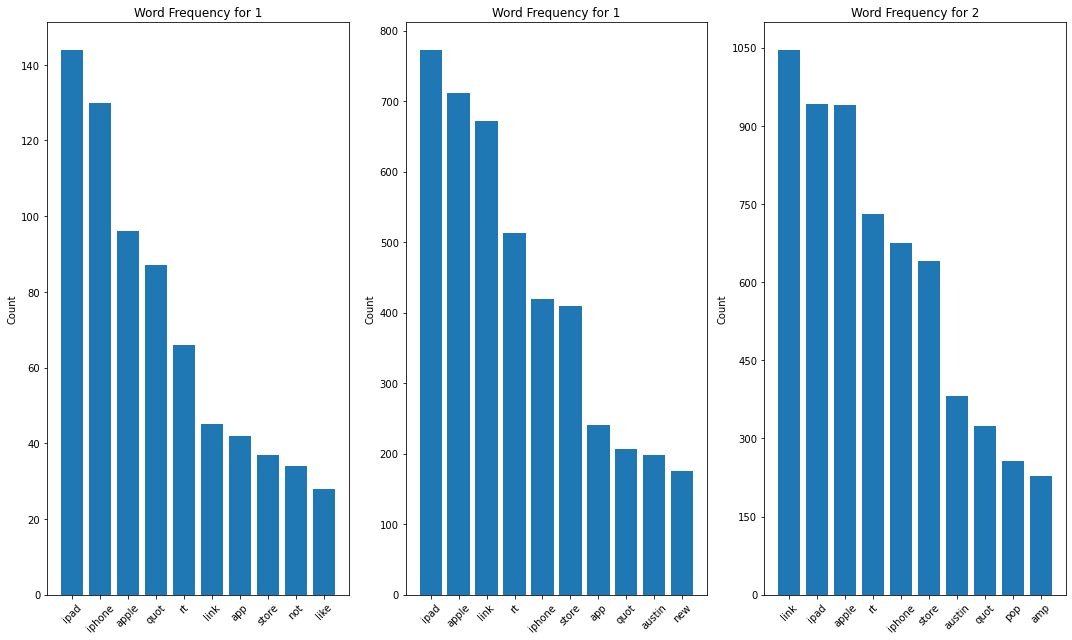

In [112]:
fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("text_without_stopwords", axes)
fig.suptitle("Word Frequencies without Stopwords", fontsize=24);

In [113]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,apple,austin,ipad,iphone,link,pop,quot,rt,store
0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0.234544,0.000000,0.441939,0.000000,0.000000,0.0,0.865840,0.000000,0.000000
2,0.0,0.000000,0.000000,0.239773,0.000000,0.244574,0.0,0.939517,0.000000,0.000000
3,0.0,0.000000,0.798265,0.000000,0.602306,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.705925,0.000000,0.0,0.000000,0.708286,0.000000
...,...,...,...,...,...,...,...,...,...,...
4185,0.0,0.405836,0.614937,0.000000,0.000000,0.000000,0.0,0.000000,0.465533,0.490335
4186,0.0,0.000000,0.798265,0.000000,0.602306,0.000000,0.0,0.000000,0.000000,0.000000
4187,0.0,0.000000,0.000000,0.533529,0.647441,0.544212,0.0,0.000000,0.000000,0.000000
4188,0.0,0.000000,0.000000,0.700063,0.000000,0.714081,0.0,0.000000,0.000000,0.000000


In [114]:
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stopwords_removed_cv.mean()

0.5446300715990454

In [115]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.5365155131264916
Stopwords removed: 0.5446300715990454


Removing stopwords (with sxsw and mention added) improved accuracy by around 1%.

# Trying Lemmatization to see if it improves model performance.

In [116]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]


In [145]:
lemmatized_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In [118]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,apple,austin,ipad,iphone,link,pop,quot,rt,store
0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0.234403,0.000000,0.441955,0.000000,0.000000,0.0,0.865870,0.000000,0.000000
2,0.0,0.000000,0.000000,0.239777,0.000000,0.244503,0.0,0.939535,0.000000,0.000000
3,0.0,0.000000,0.798265,0.000000,0.602306,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.705925,0.000000,0.0,0.000000,0.708286,0.000000
...,...,...,...,...,...,...,...,...,...,...
4185,0.0,0.406427,0.616224,0.000000,0.000000,0.000000,0.0,0.000000,0.466508,0.487294
4186,0.0,0.000000,0.798265,0.000000,0.602306,0.000000,0.0,0.000000,0.000000,0.000000
4187,0.0,0.000000,0.000000,0.533578,0.647500,0.544095,0.0,0.000000,0.000000,0.000000
4188,0.0,0.000000,0.000000,0.700173,0.000000,0.713973,0.0,0.000000,0.000000,0.000000


In [119]:
lemmatized_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
lemmatized_cv.mean()

0.5446300715990454

In [120]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Lemmatized:          ", lemmatized_cv.mean())

Stopwords removed: 0.5446300715990454
Lemmatized:           0.5446300715990454


Lemmatization offered no improvement in the models accuracy but probably increases efficiency.

# Trying Stemming to see if it improves model performance.

In [121]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [122]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [123]:
tfidf = TfidfVectorizer(
    max_features = 10,
    stop_words = stemmed_stopwords,
    tokenizer = stem_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,appl,austin,ipad,iphon,link,pop,quot,rt,store
0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0.235514,0.000000,0.437951,0.000000,0.000000,0.0,0.867601,0.000000,0.000000
2,0.0,0.000000,0.000000,0.237242,0.000000,0.245287,0.0,0.939974,0.000000,0.000000
3,0.0,0.000000,0.799014,0.000000,0.601313,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.705008,0.000000,0.0,0.000000,0.709199,0.000000
...,...,...,...,...,...,...,...,...,...,...
4185,0.0,0.406427,0.616224,0.000000,0.000000,0.000000,0.0,0.000000,0.466508,0.487294
4186,0.0,0.000000,0.799014,0.000000,0.601313,0.000000,0.0,0.000000,0.000000,0.000000
4187,0.0,0.000000,0.000000,0.528882,0.649057,0.546817,0.0,0.000000,0.000000,0.000000
4188,0.0,0.000000,0.000000,0.695221,0.000000,0.718796,0.0,0.000000,0.000000,0.000000


In [124]:
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)

In [125]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.5446300715990454
Stemmed:           0.539618138424821


Stemming actually decreased performance of the model so we will not use Stemming in our model.

# Feature engineering - will add number of sentences and whether tweet has an emoji columns

In [126]:
from nltk.tokenize import sent_tokenize

X_train["num_sentences"] = X_train["tweet_text"].apply(lambda x: len(sent_tokenize(x)))

IndexError: list index out of range

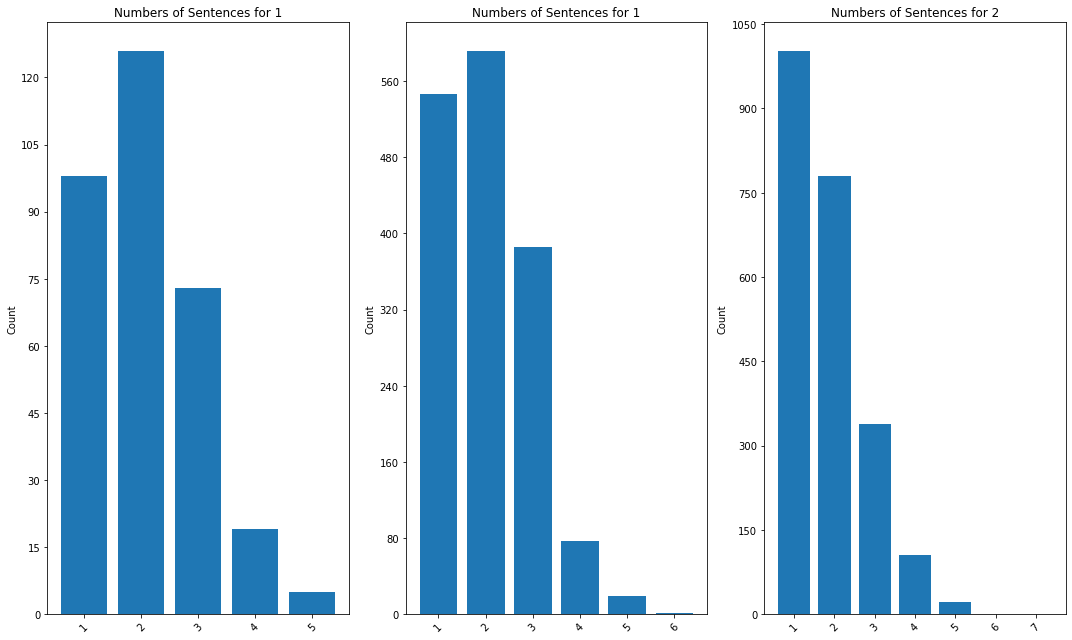

In [127]:
fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("num_sentences", axes, "Numbers of Sentences for")
fig.suptitle("Distribution of Sentence Counts by Category", fontsize=24);

IndexError: list index out of range

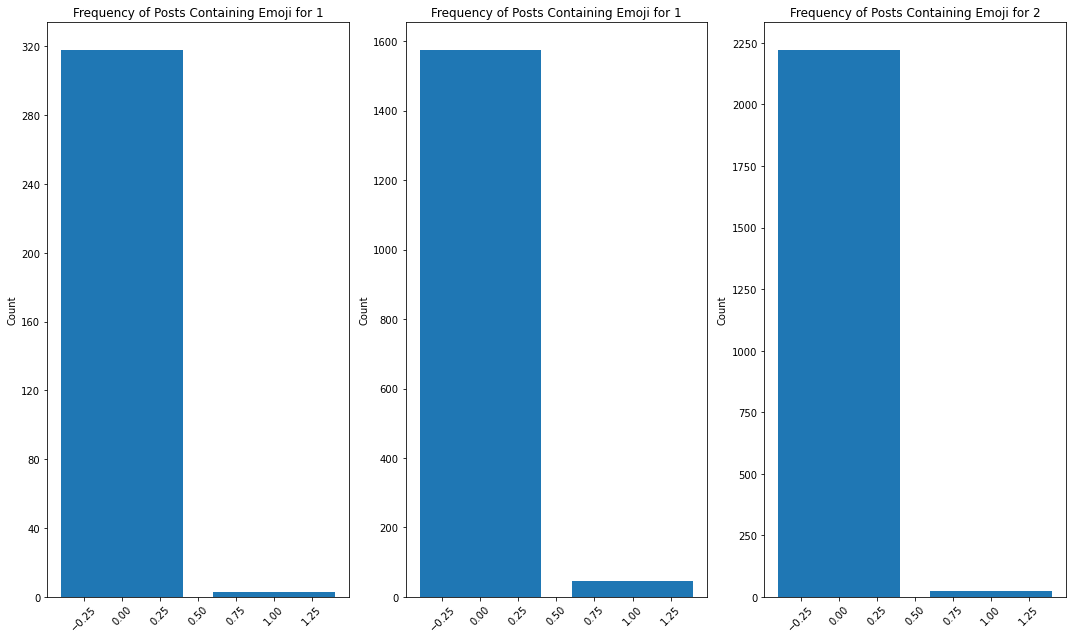

In [128]:
emoji_query = r'(?:[\:;X=B][-^]?[)\]3D([OP/\\|])(?:(?=\s))'

X_train["contains_emoji"] = X_train["tweet_text"].str.contains(emoji_query)

fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("contains_emoji", axes, "Frequency of Posts Containing Emoji for")
fig.suptitle("Distributions of Posts Containing Emoji by Category", fontsize=24);

It appears that positive posts might contain emoji's at a slightly higher rate which would make sense because a smiley face is probably the most common emoji and it would most likely be in a positive emotion tweet.

In [183]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

### Concatenating the engineered features in a new DataFrame 'preprocessed_X_train'
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())
#preprocessed_X_train = pd.concat([
    #X_train_vectorized_df, X_train[["num_sentences", "contains_emoji"]]
#], axis = 1,)

#preprocessed_X_train
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

In [184]:
### Concatenating the engineered features in a new DataFrame 'preprocessed_X_train'
preprocessed_X_train = pd.concat([
    X_train_vectorized_df.reset_index(drop=True), X_train[["num_sentences", "contains_emoji"]].reset_index(drop=True)
], axis = 1,)

preprocessed_X_train

,app,apple,austin,ipad,iphone,link,pop,quot,rt,store,num_sentences,contains_emoji
0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,3,False
1,0.0,0.234403,0.000000,0.441955,0.000000,0.000000,0.0,0.865870,0.000000,0.000000,2,False
2,0.0,0.000000,0.000000,0.239777,0.000000,0.244503,0.0,0.939535,0.000000,0.000000,3,False
3,0.0,0.000000,0.798265,0.000000,0.602306,0.000000,0.0,0.000000,0.000000,0.000000,2,False
4,0.0,0.000000,0.000000,0.000000,0.705925,0.000000,0.0,0.000000,0.708286,0.000000,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4185,0.0,0.406427,0.616224,0.000000,0.000000,0.000000,0.0,0.000000,0.466508,0.487294,3,False
4186,0.0,0.000000,0.798265,0.000000,0.602306,0.000000,0.0,0.000000,0.000000,0.000000,2,False
4187,0.0,0.000000,0.000000,0.533578,0.647500,0.544095,0.0,0.000000,0.000000,0.000000,1,False
4188,0.0,0.000000,0.000000,0.700173,0.000000,0.713973,0.0,0.000000,0.000000,0.000000,2,False


In [185]:
preprocessed_cv = cross_val_score(baseline_model, preprocessed_X_train, y_train)

In [186]:
print("Lemmatized:           ", lemmatized_cv.mean())
print("Fully preprocessed:", preprocessed_cv.mean())

Lemmatized:            0.5446300715990454
Fully preprocessed: 0.5491646778042959


- Adding the two engineered features 'num_sentences' and 'contains_emoji' improved accuracy by .5 percent

- Increasing max_features

In [201]:
tfidf = TfidfVectorizer(
    max_features = 200,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

In [202]:
final_X_train = pd.concat([
    X_train_vectorized_df.reset_index(drop=True), X_train[["num_sentences", "contains_emoji"]].reset_index(drop=True)
], axis=1)
final_X_train

,10,2011,6th,action,already,also,amp,android,anyone,app,...,winning,work,would,wow,year,yes,û_,ûï,num_sentences,contains_emoji
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440533,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3,False
4186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.513174,2,False
4187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,False
4188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,False


Setting up a pipeline and gridsearch to find the best parameters for our model

In [204]:
final_cv = cross_val_score(baseline_model, final_X_train, y_train)
print("Preprocessed:           ", preprocessed_cv.mean())
print("Final More Features:", final_cv.mean())

Preprocessed:            0.5491646778042959
Final More Features: 0.6011933174224344


In [205]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'tfidf__max_df': (.25, .5, .75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': (10, 50, 100, 200),
    'clf__alpha': (1e-2, 1e-3)
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='accuracy', cv=5)

In [206]:
grid_search.fit(preprocessed_X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [12, 4190]

In [207]:
len(preprocessed_X_train) == len(y_train)

True

In [208]:
type(preprocessed_X_train)

pandas.core.frame.DataFrame

In [209]:
type(y_train)

pandas.core.series.Series

In [210]:
final_model = MultinomialNB()

final_model.fit(final_X_train, y_train)
final_model.score(final_x_train, y_train)

NameError: name 'final_x_train' is not defined

# Namsoo

# Harshitha

## EDA